# Using AMASS for training DNNs for Human Body and Motion
AMASS is a large database of human bodies, ready to enable proper deep learning on human body. Instead of images, as in [ImageNet](http://www.image-net.org/),
 AMASS consists of human body parameters, controlling the surface mesh of the [SMPL](http://smpl.is.tue.mpg.de/) body model family.

Here we provide basic tools to turn AMASS bodies into suitable formats for deep learning frameworks.
We produce PyTorch readable *.pt*, as well as *.h5* files.

The provided data preparation code has three stages that could be flexibly customized to your own specific needs.

**Stage I** goes over the previously downloaded numpy npz files, sub-samples the time-length and dumps the result into one place as PyTorch pt files.

**Stage II** uses PyTorch to apply all sorts of data augmentations in parallel on the original data and produces HDF5 files.
HDF5 makes it possible to write files in chunks to avoid memory shortage,
while PyTorch speeds up data augmentation though batch processing .

**Stage III** simply turns the h5 files into pt files again to be readily usable by PyTorch.
One can replace this stage's output to any other suitable kind.

The progress at all stages is logged and could be inspected at any time during the process or later.
We suggest using an experiment ID that would help in referring to a specific, traceable, data preparation run.

Dependencies to run this notebook:
- [Human Body Prior](https://github.com/nghorbani/human_body_prior)
- [PyTorch>=1.7.0](https://pytorch.org/)
- [PyTables](https://www.pytables.org/usersguide/installation.html)
- [tqdm](https://pypi.org/project/tqdm/2.2.3/)

Before you continue with this tutorial, it is recommended to first take a look at the [**AMASS Visualization**](01-AMASS_Visualization.ipynb) notebook.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
from OpenGL import osmesa
ctx = osmesa.OSMesaCreateContext(osmesa.OSMESA_RGBA, None)

if ctx:
    print("OSMesa is working correctly")
    

import os
from os import path as osp

import numpy as np
import torch

support_dir = '../support_data/'

OSMesa is working correctly


In [2]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import gc
import torch
import numpy as np

# Clear CPU memory
gc.collect()

# Clear GPU memory (if using CUDA)
torch.cuda.empty_cache()


In [3]:
from human_body_prior.tools.omni_tools import log2file, makepath
from human_body_prior.tools.omni_tools import copy2cpu as c2c

We first pick an experiment ID that later helps us to identify the specific run of data preparation and augmentations.
We also prepare a message about this specific experiment, that is going to be included in our log file as future notes.

In [4]:
expr_code = 'VXX_SVXX_TXX' #VERSION_SUBVERSION_TRY

msg = ''' Initial use of standard AMASS dataset preparation pipeline '''

Then you have to download the body npz files from [AMASS](https://amass.is.tue.mpg.de/).
You would need to first register and agree to the license and pick the subsets you like from datasets.
Uncompress the body data at your desired location. The final folder structure should be like the following:

**amass_dir>sub_dataset>subjects>*_poses.npz**

Now specify the directory of the downloaded npz files and the final output folder for the prepared data, e.g. **work_dir**.
At this location at each stage of the data processing pipeline, an appropriate folder is created.
Moreover, the log file, and a snapshot of the code is created.

In [5]:
amass_dir =  '../support_data/amass_npz' #'PATH_TO_DOWNLOADED_NPZFILES/*/*_poses.npz'

work_dir = '../support_data/prepared_data/VXX_SVXX_TXX'

logger = log2file(makepath(work_dir, '%s.log' % (expr_code), isfile=True))
logger('[%s] AMASS Data Preparation Began.'%expr_code)
logger(msg)

[VXX_SVXX_TXX] AMASS Data Preparation Began.
 Initial use of standard AMASS dataset preparation pipeline 


Now we have to specify data splits for train/validation/test. Below is the recommended data splits by AMASS
for train/validation/test that chooses data for each split from non-overlapping datasets. 
One reason is to avoid similarity of marker layouts used for the original data.
Remember, AMASS is growing, and it is a good idea to check the website for new datasets.
You can also follow [AMASS twitter](https://twitter.com/mocap_amass) account for news.

In [6]:
# amass_splits = {
#     'vald': ['HumanEva', 'MPI_HDM05', 'SFU', 'MPI_mosh'],
#     'test': ['Transitions_mocap', 'SSM_synced'],
#     'train': ['CMU', 'MPI_Limits', 'TotalCapture', 'Eyes_Japan_Dataset', 'KIT',
#               'BML', 'EKUT', 'TCD_handMocap', 'ACCAD']
# }
amass_splits = {
    'vald': ['SFU',],
    'test': ['SSM_synced'],
    'train': ['MPI_Limits']
}
amass_splits['train'] = list(set(amass_splits['train']).difference(set(amass_splits['test'] + amass_splits['vald'])))

Now we have everything in place to run the preparation code.
Take a look at the code for **prepare_amass** and customize it to your need.

In [7]:
# from amass.data.prepare_data import prepare_amass
# prepare_amass(amass_splits, amass_dir, work_dir, logger=logger)

## Visualize the prepared data
Now we can try to open them with PyTorch which a dataloader:

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import os

class AMASS_DS(Dataset):
    """Loads AMASS data for a single subject from a saved PyTorch dataset."""

    def __init__(self, subject_id, dataset_dir, num_betas=16):
        """
        Args:
            subject_id (str): Subject ID to load.
            dataset_dir (str): Path to the directory containing per-subject .pt datasets.
            num_betas (int): Number of shape parameters to use.
        """
        self.dataset_path = os.path.join(dataset_dir, f"{subject_id}_dataset.pt")

        if not os.path.exists(self.dataset_path):
            raise FileNotFoundError(f"Dataset for subject {subject_id} not found in {dataset_dir}")

        self.ds = torch.load(self.dataset_path)
        self.num_betas = num_betas

    def __len__(self):

        
        return len(self.ds['pose'])

    def __getitem__(self, idx):
        data = {k: self.ds[k][idx] for k in self.ds.keys()}
        
        # Separate root orientation, body pose, and hands
        data['root_orient'] = data['pose'][:3]
        data['pose_body'] = data['pose'][3:66]  # Body joints only
        data['pose_hand'] = data['pose'][66:]  # Hands only
        data['betas'] = data['betas'][:self.num_betas]  # Shape parameters

        return data

# Example usage
subject_id = "0005_2FeetJump001"  # Change this to the subject you want to load
subject_dir = os.path.join(work_dir, 'stage_III', 'vald')

ds = AMASS_DS(subject_id=subject_id, dataset_dir=subject_dir, num_betas=16)
print(f'Subject {subject_id} has {len(ds)} frames.')

batch_size = 5
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)


Subject 0005_2FeetJump001 has 2560 frames.


In [9]:
# from torch.utils.data.sampler import Sampler
# class AMASS_DS(Dataset):
#     """AMASS subject-wise DataLoader."""

#     def __init__(self, dataset_dir, num_betas=16):
#         self.subjects = sorted([os.path.join(dataset_dir, subj) for subj in os.listdir(dataset_dir)
#                                 if os.path.isdir(os.path.join(dataset_dir, subj))])
#         self.num_betas = num_betas
#         self.data_index = self.build_index()

#     def __getitem__(self, idx):
#         subj_path, frame_idx = self.data_index[idx]
#         data = {}

#         # Load subject-wise data
#         data['pose'] = torch.load(os.path.join(subj_path, 'pose.pt'))[frame_idx]
#         data['trans'] = torch.load(os.path.join(subj_path, 'trans.pt'))[frame_idx]

#         betas = torch.load(os.path.join(subj_path, 'betas.pt'))[0]  # Betas are same for all frames
#         if betas.shape[0] < self.num_betas:
#             betas = torch.cat([betas, torch.zeros(self.num_betas - betas.shape[0])], dim=0)  # Pad if needed
#         data['betas'] = betas[:self.num_betas]

#         data['gender'] = torch.load(os.path.join(subj_path, 'gender.pt'))[0]

#         # Extract structured pose information
#         data['root_orient'] = data['pose'][:3]
#         data['pose_body'] = data['pose'][3:66]
#         data['pose_hand'] = data['pose'][66:]

#         return data

# batch_size = 5
# sampler = SubjectSampler(ds.data_index, batch_size)

# dataloader = DataLoader(ds, batch_sampler=sampler, num_workers=5)

# # Test batch subject consistency
# for batch in dataloader:
#     print(batch['pose'].shape)  # Expected: (batch_size, num_frames, 159)
#     break


In [10]:
sample = ds[0]  # Load first sample
print(sample['pose'].shape)  # Expected: (num_frames, 159)


torch.Size([156])


We can use the tutorial in [**AMASS Visualization**](01-AMASS_Visualization.ipynb) to visualize the data

In [11]:
import trimesh
from body_visualizer.tools.vis_tools import colors, imagearray2file
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.tools.vis_tools import show_image

import os
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'

imw, imh=400, 400
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

In [13]:
from human_body_prior.body_model.body_model import BodyModel

bm_fname = osp.join(support_dir, 'body_models/smplh/male/model.npz')

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas).to(comp_device)
faces = c2c(bm.f)

bdata = next(iter(dataloader))
body_v = bm.forward(**{k:v.to(comp_device) for k,v in bdata.items() if k in ['pose_body', 'betas']}).v


In [ ]:
view_angles = [0, 180, 90, -90]
images = np.zeros([len(view_angles), batch_size, 1, imw, imh, 3])
for cId in range(0, batch_size):

    orig_body_mesh = trimesh.Trimesh(vertices=c2c(body_v[cId]), faces=c2c(bm.f), vertex_colors=np.tile(colors['grey'], (6890, 1)))

    for rId, angle in enumerate(view_angles):
        if angle != 0: orig_body_mesh.apply_transform(trimesh.transformations.rotation_matrix(np.radians(angle), (0, 1, 0)))
        mv.set_meshes([orig_body_mesh], group_name='static')
        images[rId, cId, 0] = mv.render()

        if angle != 0: orig_body_mesh.apply_transform(trimesh.transformations.rotation_matrix(np.radians(-angle), (0, 1, 0)))


IndexError: index 5 is out of bounds for dimension 0 with size 5

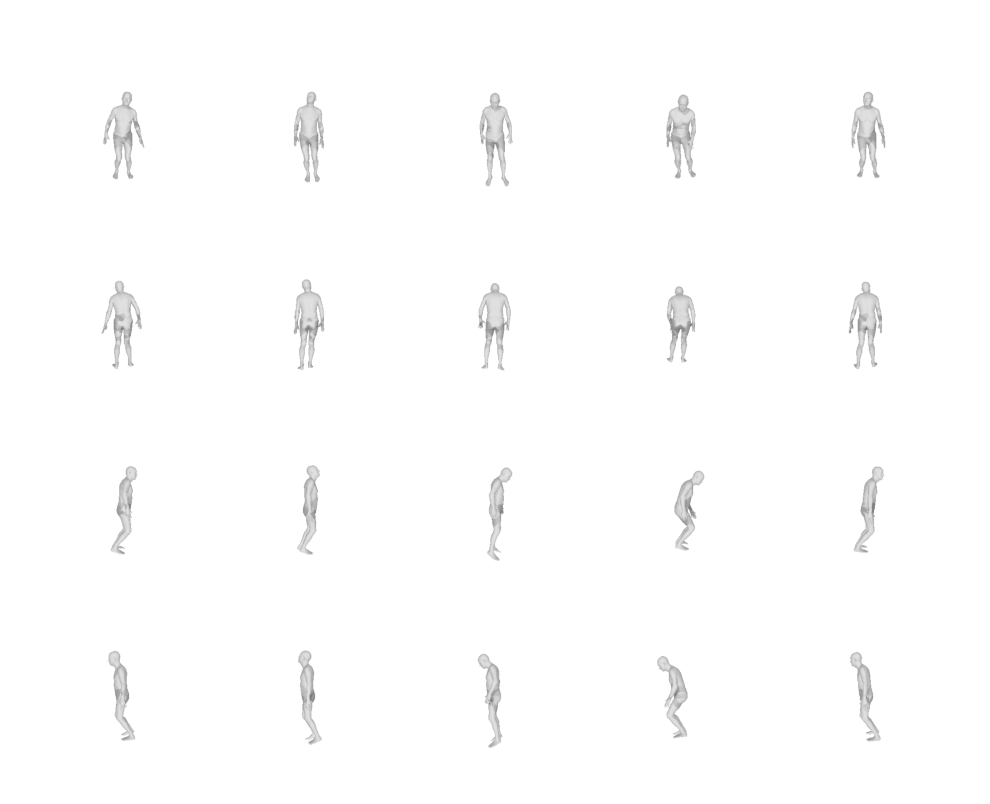

In [ ]:
img = imagearray2file(images)
show_image(np.array(img)[0])

In the above image each column is a data point and at each row we rotate the body to visualize it from different angles.
AMASS has been recently used to train a human body prior for advanced human body inverse kinematics.
Take a look at the paper [Expressive Body Capture: 3D Hands, Face, and Body from a Single Image](https://smpl-x.is.tue.mpg.de/)
and the [VPoser](https://github.com/nghorbani/human_body_prior)  GitHub page for further information.
VPoser is capable of generating new body poses for SMPL body model.

In [ ]:
import os
import numpy as np

# Ruta a uno de los archivos .npz dentro de uno de los datasets
dataset_name = "MPI_Limits"  # Puedes cambiarlo por 'SFU' o 'SSM_synced'
dataset_path = os.path.join("../support_data/amass_npz", dataset_name)
npz_files = [f for f in os.listdir(dataset_path) if f.endswith("_poses.npz")]

# Elegimos el primer archivo para inspeccionar
npz_file = os.path.join(dataset_path, npz_files[0])

# Cargar el archivo .npz
data = np.load(npz_file)

# Mostrar las claves disponibles en el archivo
print("Claves en el archivo NPZ:", list(data.keys()))

# Mostrar la forma de cada clave
for key in data.keys():
    print(f"{key}: {data[key].shape}")


Claves en el archivo NPZ: ['trans', 'gender', 'mocap_framerate', 'betas', 'dmpls', 'poses']
trans: (5922, 3)
gender: ()
mocap_framerate: ()
betas: (16,)
dmpls: (5922, 8)
poses: (5922, 156)


In [ ]:
data['poses']

NameError: name 'data' is not defined

In [ ]:
# Mostrar los primeros 5 frames de 'poses'
print("Primeros 5 frames de 'poses':\n", data['poses'][:5])


NameError: name 'data' is not defined

In [ ]:
from human_body_prior.body_model.body_model import BodyModel
import os

# Ruta del modelo SMPL
support_dir = "../support_data/"  # Asegúrate de que este es el directorio correcto
bm_fname = os.path.join(support_dir, "body_models/smplh/male/model.npz")

# Cargar el modelo
bm = BodyModel(bm_fname=bm_fname, num_betas=16)

# Obtener los nombres de las articulaciones
print("Índices de las articulaciones en SMPL:", bm.kintree_table)



Índices de las articulaciones en SMPL: tensor([[-1,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9,  9, 12, 13, 14,
         16, 17, 18, 19, 20, 22, 23, 20, 25, 26, 20, 28, 29, 20, 31, 32, 20, 34,
         35, 21, 37, 38, 21, 40, 41, 21, 43, 44, 21, 46, 47, 21, 49, 50],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]],
       dtype=torch.int32)


In [ ]:
import torch
from human_body_prior.body_model.body_model import BodyModel
import os

# Cargar el modelo SMPL
support_dir = "../support_data/"  # Asegúrate de que sea correcto
bm_fname = os.path.join(support_dir, "body_models/smplh/male/model.npz")
bm = BodyModel(bm_fname=bm_fname, num_betas=16)

# Crear una configuración neutral (sin pose, solo la forma base)
pose_zero = torch.zeros(1, 156)  # 52 articulaciones * 3 valores de axis-angle
betas_zero = torch.zeros(1, 16)  # 16 parámetros de forma
trans_zero = torch.zeros(1, 3)   # Sin traslación

# Generar la malla del cuerpo
body_output = bm(pose=pose_zero, betas=betas_zero, trans=trans_zero)

# Obtener las posiciones de las articulaciones en la pose base
joint_positions = body_output.Jtr[0].detach().numpy()  # (52, 3)

# Mostrar las primeras articulaciones
print("Posiciones de las primeras articulaciones en la pose base:\n", joint_positions[:10])


Posiciones de las primeras articulaciones en la pose base:
 [[-0.00217368 -0.24078918  0.02858379]
 [ 0.05640767 -0.32306919  0.01091971]
 [-0.06248341 -0.33130246  0.01504126]
 [ 0.00226577 -0.11638561 -0.00980143]
 [ 0.09985909 -0.70953864  0.01895671]
 [-0.10574003 -0.7149903   0.01019822]
 [ 0.00675421  0.02157077  0.0170189 ]
 [ 0.08506877 -1.1364131  -0.01847128]
 [-0.0866845  -1.1350359  -0.02436345]
 [ 0.00448963  0.07760316  0.01987394]]


In [ ]:
import numpy as np

# Calcular el rango de valores en 'poses'
min_val = np.min(data['poses'])
max_val = np.max(data['poses'])

print(f"Rango de valores en 'poses': {min_val} a {max_val}")

Rango de valores en 'poses': -1.8242368111236695 a 2.743772155895454


In [ ]:
import numpy as np

# Definir las 24 articulaciones principales en SMPL (índices en la matriz de poses)
important_joints = np.array([
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23
])

# Como cada articulación tiene 3 valores (axis-angle), necesitamos multiplicar los índices por 3
idx = np.concatenate([important_joints * 3, important_joints * 3 + 1, important_joints * 3 + 2])

# Extraer solo las articulaciones seleccionadas
selected_poses = data['poses'][:, idx]

print("Nueva forma de 'selected_poses':", selected_poses.shape)
print("Primeros 5 frames de las 24 articulaciones:\n", selected_poses[:5])


Nueva forma de 'selected_poses': (5922, 72)
Primeros 5 frames de las 24 articulaciones:
 [[ 1.67982094e+00 -6.47008055e-02 -8.14504383e-02 -6.97474007e-04
  -8.83034639e-02 -5.66313008e-02 -2.41425091e-01 -1.45193091e-01
  -1.47139455e-01  2.38672102e-01  0.00000000e+00  0.00000000e+00
   6.16011364e-02 -2.26382234e-01 -1.51557754e-01 -1.31226662e-01
  -2.36515454e-01 -2.26804541e-01 -6.06317123e-01 -3.71796054e-02
  -3.43849295e-01  2.55084642e-01  1.11678716e-01  1.08811325e-01
   2.33404933e-02  1.85041306e-02 -6.41539766e-02  1.32249016e-02
  -1.70620338e-01  1.94772004e-01 -3.17057824e-02  3.60400837e-01
  -2.70488315e-01  1.46674918e-02  0.00000000e+00  0.00000000e+00
  -3.32849599e-02  3.05206829e-01 -2.87566834e-01  7.37334450e-03
  -1.28523376e-01 -5.59769131e-02 -4.79336489e-01  1.80612604e-01
  -2.53873572e-01  9.61307196e-03  4.28921748e-02 -6.59856789e-02
   1.31383884e-02 -2.26272945e-03 -3.89636527e-03  1.40831300e-03
   9.96150806e-02 -2.05788273e-02 -1.96332908e-02  1.

In [ ]:
import torch
from human_body_prior.tools.rotation_tools import aa2matrot

# Convertir a torch.Tensor y asegurar que los datos sean contiguos
selected_poses_torch = torch.tensor(selected_poses, dtype=torch.float32).contiguous()

# Convertir de axis-angle a matrices de rotación
rot_matrices = aa2matrot(selected_poses_torch.reshape(-1, 3)).reshape(selected_poses_torch.shape[0], -1, 3, 3)

print("Nueva forma de 'rot_matrices':", rot_matrices.shape)  # Debe ser (N_frames, 24, 3, 3)
print("Ejemplo de matriz de rotación para la primera articulación del primer frame:\n", rot_matrices[0, 0])


Nueva forma de 'rot_matrices': torch.Size([5922, 24, 3, 3])
Ejemplo de matriz de rotación para la primera articulación del primer frame:
 tensor([[ 0.9958,  0.0054, -0.0919],
        [-0.0908, -0.1104, -0.9897],
        [-0.0155,  0.9939, -0.1094]])


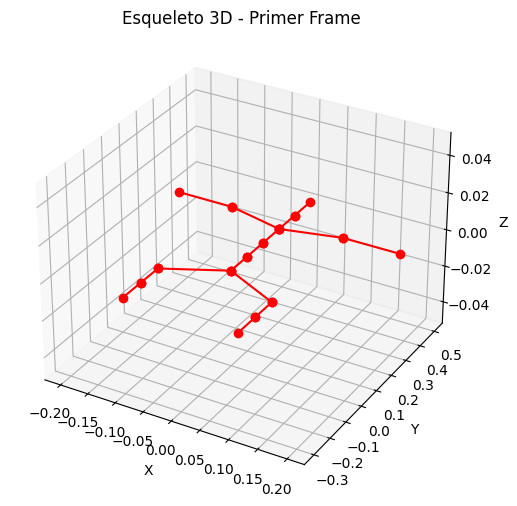

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definir la estructura del esqueleto SMPL (conexiones entre articulaciones principales)
skeleton_connections = [
    (0, 1), (1, 2), (2, 3),  # Espina dorsal
    (3, 4), (4, 5),  # Brazo izquierdo
    (3, 6), (6, 7),  # Brazo derecho
    (0, 8), (8, 9), (9, 10),  # Pierna izquierda
    (0, 11), (11, 12), (12, 13),  # Pierna derecha
    (3, 14), (14, 15),  # Cuello y cabeza
]

# Crear una pose base (posición de articulaciones en coordenadas 3D)
transformed_pose = np.array([
    [0, 0, 0],  # Pelvis (raíz)
    [0, 0.1, 0], [0, 0.2, 0], [0, 0.3, 0],  # Espina dorsal
    [-0.1, 0.35, 0], [-0.2, 0.35, 0],  # Brazo izquierdo
    [0.1, 0.35, 0], [0.2, 0.35, 0],  # Brazo derecho
    [-0.1, -0.1, 0], [-0.1, -0.2, 0], [-0.1, -0.3, 0],  # Pierna izquierda
    [0.1, -0.1, 0], [0.1, -0.2, 0], [0.1, -0.3, 0],  # Pierna derecha
    [0, 0.4, 0], [0, 0.5, 0]  # Cuello y cabeza
])

# Tomar el primer frame de rotaciones
rotations = rot_matrices[0].numpy()

# Aplicar las rotaciones a la pose base
# transformed_pose = np.array([rotations[i] @ base_pose[i] for i in range(len(base_pose))])

# Visualizar el esqueleto
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for joint1, joint2 in skeleton_connections:
    ax.plot(
        [transformed_pose[joint1, 0], transformed_pose[joint2, 0]],
        [transformed_pose[joint1, 1], transformed_pose[joint2, 1]],
        [transformed_pose[joint1, 2], transformed_pose[joint2, 2]],
        'ro-'
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Esqueleto 3D - Primer Frame")

plt.show()


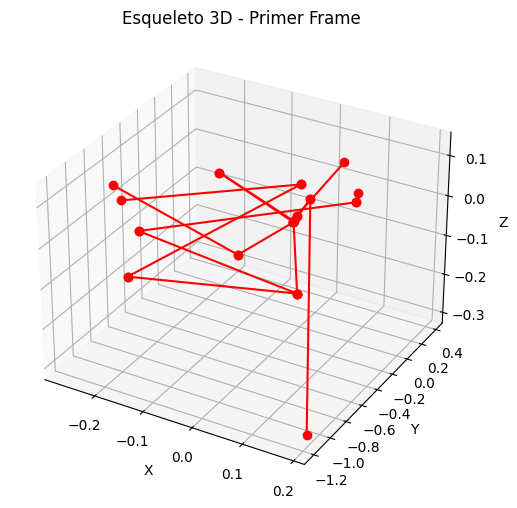

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Índices de las articulaciones relevantes en SMPL (ajustado a las 24 seleccionadas)
important_joints = np.array([
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23
])

# Filtrar solo las posiciones de las 24 articulaciones seleccionadas
joint_positions_selected = joint_positions[important_joints]

# Tomar el primer frame de rotaciones
rotations = rot_matrices[0].numpy()

# Aplicar rotaciones a las posiciones base
transformed_joints = np.array([rotations[i] @ joint_positions_selected[i] for i in range(len(joint_positions_selected))])

# Definir conexiones del esqueleto en SMPL
skeleton_connections = [
    (0, 1), (1, 2), (2, 3),  # Espina dorsal
    (3, 4), (4, 5),  # Brazo izquierdo
    (3, 6), (6, 7),  # Brazo derecho
    (0, 8), (8, 9), (9, 10),  # Pierna izquierda
    (0, 11), (11, 12), (12, 13),  # Pierna derecha
    (3, 14), (14, 15),  # Cuello y cabeza
]

# Graficar el esqueleto en 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for joint1, joint2 in skeleton_connections:
    ax.plot(
        [transformed_joints[joint1, 0], transformed_joints[joint2, 0]],
        [transformed_joints[joint1, 1], transformed_joints[joint2, 1]],
        [transformed_joints[joint1, 2], transformed_joints[joint2, 2]],
        'ro-'
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Esqueleto 3D - Primer Frame")
plt.show()


In [ ]:
import numpy as np

# Definir las 24 articulaciones principales en SMPL (índices en la matriz de poses)
important_joints = np.array([
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23
])

# Como cada articulación tiene 3 valores (axis-angle), necesitamos multiplicar los índices por 3
idx = np.concatenate([important_joints * 3, important_joints * 3 + 1, important_joints * 3 + 2])

# Extraer solo las articulaciones seleccionadas
selected_poses = data['poses'][:, idx]

print("Nueva forma de 'selected_poses':", selected_poses.shape)
print("Primeros 5 frames de las 24 articulaciones:\n", selected_poses[:5])


Nueva forma de 'selected_poses': (5922, 72)
Primeros 5 frames de las 24 articulaciones:
 [[ 1.67982094e+00 -6.47008055e-02 -8.14504383e-02 -6.97474007e-04
  -8.83034639e-02 -5.66313008e-02 -2.41425091e-01 -1.45193091e-01
  -1.47139455e-01  2.38672102e-01  0.00000000e+00  0.00000000e+00
   6.16011364e-02 -2.26382234e-01 -1.51557754e-01 -1.31226662e-01
  -2.36515454e-01 -2.26804541e-01 -6.06317123e-01 -3.71796054e-02
  -3.43849295e-01  2.55084642e-01  1.11678716e-01  1.08811325e-01
   2.33404933e-02  1.85041306e-02 -6.41539766e-02  1.32249016e-02
  -1.70620338e-01  1.94772004e-01 -3.17057824e-02  3.60400837e-01
  -2.70488315e-01  1.46674918e-02  0.00000000e+00  0.00000000e+00
  -3.32849599e-02  3.05206829e-01 -2.87566834e-01  7.37334450e-03
  -1.28523376e-01 -5.59769131e-02 -4.79336489e-01  1.80612604e-01
  -2.53873572e-01  9.61307196e-03  4.28921748e-02 -6.59856789e-02
   1.31383884e-02 -2.26272945e-03 -3.89636527e-03  1.40831300e-03
   9.96150806e-02 -2.05788273e-02 -1.96332908e-02  1.